## Semantic Similarity

In [11]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import re
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# set the option to display all columns
pd.set_option('display.max_columns', None)

## GPT 4 Tweets Semantic Similarity 

In [5]:
gpt4 = pd.read_csv('gpt4_full_merged.csv')
gpt4 = gpt4[(gpt4['gpt4_simple'].str.len() >246) & (gpt4['gpt4_simple'].str.len() < 322)]

In [9]:
# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

gpt4['text'] = gpt4['text'].apply(remove_urls)
gpt4['text'] = gpt4['text'].str.replace(r'\\n', ' ', regex=True)

In [13]:
# drop duplicates 
gpt4 = gpt4.drop_duplicates(subset='text')

# find tweets commenting on the same news 
duplicated = gpt4[gpt4.duplicated(subset=['link_text'], keep=False)]

In [14]:
duplicated.head()

,id,author_id,in_reply_to_user_id,quoted_user_id,retweeted_user_id,text,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,entities.hashtags,entities.mentions,author.username,author.name,author.description,author.location,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.tweet_count,url,link_text,party,name,Occupation(s),Education,Residence[5],sentiment,age,gender,gpt4_simple,gpt4_simple_sentiment,gpt4_no_polit,gpt4_no_polit_label,gpt4_name,gpt4_name_label,gpt4_using,gpt4_using_label,gpt4_arg,gpt4_arg_label,gpt4_edu,gpt4_edu_label,gpt4_age,gpt4_age_label,gpt4_gender,gpt4_gender_label,text_text_emotion,text_emotion_score,gpt4_simple_text_emotion,gpt4_simple_emotion_score,gpt4_no_polit_text_emotion,gpt4_no_polit_emotion_score,gpt4_name_text_emotion,gpt4_name_emotion_score,gpt4_using_text_emotion,gpt4_using_emotion_score,gpt4_arg_text_emotion,gpt4_arg_emotion_score,gpt4_edu_text_emotion,gpt4_edu_emotion_score,gpt4_age_text_emotion,gpt4_age_emotion_score,gpt4_gender_text_emotion,gpt4_gender_emotion_score,gpt4_simple_bert_sentiment,gpt4_no_polit_bert_class,gpt4_using_bert_class,gpt4_arg_bert_class,gpt4_edu_bert_class,gpt4_gender_bert_class,gpt4_age_bert_class
4,1255486188892422149,1080960924687704064,NaN,NaN,NaN,The coronavirus pandemic continues to highligh...,8,1,1,2,NaN,"[{""start"": 231, ""end"": 235, ""username"": ""FTC"",...",SenHawleyPress,Senator Hawley Press Office,Tweets from the office of U.S. Senator Josh Ha...,Missouri,58953,857,4437,https://www.kfvs12.com/2020/04/29/sen-hawley-c...,WASHINGTON D.C. (KFVS) - U.S. Senators Josh Ha...,Republican,Josh Hawley,Lawyer Professor,Stanford University (BA) Yale University (JD),Ozark,neutral,44,male,Our meat supply is vital to our national secur...,positive,Senators Hawley and Baldwin's call for an FTC ...,positive,The closure,neutral,Proud to see @HawleyMO taking a stand for Amer...,positive,.@HawleyMO and @SenatorBaldwin are right—Ameri...,positive,👍 Great to see bipartisan efforts by @HawleyMO...,positive,Strongly support the bipartisan call from @Haw...,positive,Great to see bipartisan support for protecting...,positive,fear,0.722075,fear,0.978316,fear,0.978900,sadness,0.952950,fear,0.879927,fear,0.982180,fear,0.966697,fear,0.978177,fear,0.979275,neutral,neutral,positive,neutral,positive,positive,positive
20,1515026813856239620,18695134,NaN,NaN,NaN,GOP-led states across the country are so confi...,23,1,10,10,"[{""start"": 51, ""end"": 58, ""tag"": ""SCOTUS""}]",NaN,SenatorMenendez,Senator Bob Menendez,U.S. Senator from New Jersey. @SFRCdems Chairm...,"New Jersey, USA",216622,1058,18988,https://www.washingtonpost.com/politics/2022/0...,Listen Comment on this story Comment Gift Arti...,Democrat,Bob Menendez,Lawyer,Saint Peter's University (BA) Rutgers Law Scho...,Englewood Cliffs[24],negative,70,male,It's heartbreaking to see states like Kentucky...,negative,These recent anti-abortion laws are alarming a...,negative,These GOP,negative,The wave of restrictive anti-abortion laws swe...,negative,These draconian anti-abortion laws are an assa...,negative,Draconian anti-abortion laws are jeopardizing ...,negative,These draconian abortion bans are a direct ass...,negative,As GOP-led states push their agendas to restri...,positive,fear,0.934100,fear,0.859390,fear,0.951824,neutral,0.892198,fear,0.585286,fear,0.718754,fear,0.774308,fear,0.768018,fear,0.870330,negative,negative,negative,negative,negative,negative,negative
21,1367119920316772358,817138492614524928,NaN,NaN,1.341121e+18,"""The ""For the People Act"" is about taking away...",43,2,17,15,"[{""start"": 238, ""end"": 246, ""tag"": ""FoxNews""}]","[{""start"": 171, ""end"": 182, ""username"": ""RepCh...",SenTedBuddNC,Senator Ted Budd,Official account for North Carolina U.S. Senat...,"Davie County, North Carolina",50033,770,3862,https://www.foxnews.com/opinion/pelosi-schumer...,NEW You can now listen to Fox News articles!\n...,

In [15]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [16]:
columns = ['gpt4_simple', 'gpt4_no_polit', 'gpt4_name', 
           'gpt4_using', 'gpt4_arg', 'gpt4_edu', 'gpt4_age', 'gpt4_gender']

In [17]:
def get_embeddings(sentence, tokenizer, model):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=128)
    
    # Forward pass, no gradient calculation needed
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the hidden states from the model
    hidden_state = outputs.last_hidden_state
    
    embeddings = hidden_state[:, 0, :] # extract the embedding
        
    return embeddings

## Same News

### Similarity True and Generated

In [18]:
similarity_gen = []

In [19]:
# Iterate over the rows and columns to calculate similarities
for index, row in tqdm(duplicated.iterrows(), total=duplicated.shape[0]):
    sentence1 = str(row['text'])
    
    similarity_row = {}
    
    for column in columns:
        sentence2 = str(row[column])
        
        # Get embeddings for both sentences
        embedding1 = get_embeddings(sentence1, tokenizer, model)
        embedding2 = get_embeddings(sentence2, tokenizer, model)
        
        # Calculate cosine similarity
        similarity = cosine_similarity(embedding1.numpy(), embedding2.numpy())  # Convert tensors to numpy arrays
        similarity_row[f'similarity_{column}'] = similarity[0][0]
    
    # Append the similarity row to the list
    similarity_gen.append(similarity_row)

100%|█████████████████████████████████████████| 636/636 [09:44<00:00,  1.09it/s]


In [20]:
duplicated = duplicated.reset_index()
similarity_gen_df = pd.DataFrame(similarity_gen)
similarity_gen_df['link_text'] = duplicated['link_text']

In [21]:
similarities_gen_pivot = similarity_gen_df.pivot_table(index='link_text', values=['similarity_gpt4_simple', 'similarity_gpt4_no_polit',
       'similarity_gpt4_name', 'similarity_gpt4_using', 'similarity_gpt4_arg',
       'similarity_gpt4_edu', 'similarity_gpt4_age', 'similarity_gpt4_gender'],  aggfunc='mean')
similarities_gen_pivot = similarities_gen_pivot.reset_index()

In [22]:
similarities_gen_pivot.head()

,link_text,similarity_gpt4_age,similarity_gpt4_arg,similarity_gpt4_edu,similarity_gpt4_gender,similarity_gpt4_name,similarity_gpt4_no_polit,similarity_gpt4_simple,similarity_gpt4_using
0,"\n\n\n\n\n\n\n\n\n\n\n\n\n\nWASHINGTON, June 1...",0.837654,0.829469,0.840495,0.841256,0.785166,0.857202,0.837858,0.827254
1,\n\nA divided Supreme Court late Wednesday ref...,0.870482,0.893538,0.890163,0.886592,0.726190,0.911576,0.894551,0.867009
2,"\n\nEditors’ Note, June 5, 2020:\n\nAfter publ...",0.829361,0.832208,0.811869,0.813040,0.740664,0.811405,0.813875,0.830763
3,\n\nElizabeth Warren is a Democratic senator f...,0.851854,0.856729,0.846154,0.851462,0.750957,0.858109,0.831880,0.870966
4,\n\nMarbell Castillo holds her granddaughter M...,0.877687,0.871502,0.887493,0.848762,0.810514,0.864861,0.859547,0.844270


In [57]:
similarities_gen_pivot.to_csv('similarities_gpt4.csv', index=False)

### Similarity between true tweets

In [23]:
similarity_true = []

In [24]:
# Group by 'link_text' and process each group separately
for name, group in tqdm(duplicated.groupby('link_text'), total=duplicated['link_text'].nunique()):
    embeddings = []
    
    # Calculate embeddings for each text in the group
    for text in group['text']:
        embedding = get_embeddings(text, tokenizer, model)
        embeddings.append(embedding)
    
    # Calculate cosine similarity between each pair of embeddings in the group
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            similarity = cosine_similarity(embeddings[i].numpy(), embeddings[j].numpy())
            similarity_true.append((name, group.iloc[i]['text'], group.iloc[j]['text'], similarity.item()))


100%|█████████████████████████████████████████| 252/252 [00:38<00:00,  6.62it/s]


In [25]:
# Convert similarities to DataFrame for better readability
similarities_df = pd.DataFrame(similarity_true, columns=['link_text', 'text1', 'text2', 'similarity'])

In [26]:
similarities_df['similarity'].mean()

0.8337459682900492

In [27]:
pivot_table = similarities_df.pivot_table(index='link_text', values='similarity',  aggfunc='mean')
pivot_table = pivot_table.reset_index()

In [28]:
pivot_table['similarity'].mean()

0.8618725859287724

In [29]:
pivot_table.head()

,link_text,similarity
0,"\n\n\n\n\n\n\n\n\n\n\n\n\n\nWASHINGTON, June 1...",0.895290
1,\n\nA divided Supreme Court late Wednesday ref...,0.931092
2,"\n\nEditors’ Note, June 5, 2020:\n\nAfter publ...",0.806969
3,\n\nElizabeth Warren is a Democratic senator f...,0.867557
4,\n\nMarbell Castillo holds her granddaughter M...,0.881336


In [83]:
pivot_table.to_csv('similarity_tt_same.csv', index= False)

## Similarity between generated tweets

In [30]:
generated_same_news_sim = []

In [31]:
# Group by 'link_text' and process each group separately
for name, group in tqdm(duplicated.groupby('link_text'), total=duplicated['link_text'].nunique()):
    embeddings = []
    
    # Calculate embeddings for each text in the group
    for text in group['gpt4_simple']:
        embedding = get_embeddings(text, tokenizer, model)
        embeddings.append(embedding)
    
    # Calculate cosine similarity between each pair of embeddings in the group
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            similarity = cosine_similarity(embeddings[i].numpy(), embeddings[j].numpy())
            generated_same_news_sim.append((name, group.iloc[i]['gpt4_simple'], group.iloc[j]['gpt4_simple'], similarity.item()))

100%|█████████████████████████████████████████| 252/252 [00:25<00:00,  9.73it/s]


In [32]:
# Convert similarities to DataFrame for better readability
similarities_fake = pd.DataFrame(generated_same_news_sim, columns=['link_text', 'text1', 'text2', 'similarity'])

In [34]:
similarities_fake['similarity'].mean()

0.9224200526328936

In [35]:
generated_same_news_sim = pd.DataFrame(generated_same_news_sim, columns=['link_text', 'text1', 
                                                                         'text2', 'similarity'])

generated_same_news_sim.to_csv('gpt4_ff_same_news.csv', index=False)


In [55]:
generated_same_news_sim = pd.read_csv('gpt4_ff_same_news.csv')

## Different News

### Similarity generated and true tweets

In [37]:
# Drop duplicates based on the 'link text' column
diff = duplicated.drop_duplicates(subset='link_text')

In [38]:
true_gen_diff_news_sim = []

In [39]:
# Iterate over all rows in the dataframe
for index, row in tqdm(diff.iterrows(), total=diff.shape[0]):
    sentence1 = str(row['gpt4_simple'])
    embedding1 = get_embeddings(sentence1, tokenizer, model)
    
    similarity_row = {}

    for ind, row2 in diff.iloc[index+1:].iterrows():
        sentence2 = str(row2['text'])
        
        # Get embeddings for both sentences
        embedding2 = get_embeddings(sentence2, tokenizer, model)
        
        # Calculate cosine similarity
        similarity = cosine_similarity(embedding1.numpy(), embedding2.numpy())
        
        # Store similarity score
        similarity_row[f'similarity_{ind}'] = similarity

    # Append the similarity row to the list
    true_gen_diff_news_sim.append(similarity_row)

100%|█████████████████████████████████████████| 252/252 [13:28<00:00,  3.21s/it]


In [40]:
# Extracting values and creating dataframe
similarity_values = [value[0][0] for d in true_gen_diff_news_sim for value in d.values()]
true_gen_diff_news_sim1 = pd.DataFrame(similarity_values, columns=['similarity'])

In [41]:
true_gen_diff_news_sim1.to_csv('true_gen_diff_news_sim1.csv', index=False)

### Similarity generated tweets 

In [42]:
generated_diff_news_sim = []

In [43]:
# Iterate over all rows in the dataframe
for index, row in tqdm(diff.iterrows(), total=diff.shape[0]):
    sentence1 = str(row['gpt4_simple'])
    embedding1 = get_embeddings(sentence1, tokenizer, model)
    
    similarity_row = {}

    for ind, row2 in diff.iloc[index+1:].iterrows():
        sentence2 = str(row2['gpt4_simple'])
        
        # Get embeddings for both sentences
        embedding2 = get_embeddings(sentence2, tokenizer, model)
        
        # Calculate cosine similarity
        similarity = cosine_similarity(embedding1.numpy(), embedding2.numpy())
        
        # Store similarity score
        similarity_row[f'similarity_{ind}'] = similarity

    # Append the similarity row to the list
    generated_diff_news_sim.append(similarity_row)

100%|█████████████████████████████████████████| 252/252 [16:20<00:00,  3.89s/it]


In [44]:
# Extracting values and creating dataframe
values_ff_dif_news = [value[0][0] for d in generated_diff_news_sim for value in d.values()]
values_ff_dif_news = pd.DataFrame(values_ff_dif_news, columns=['similarity'])

In [45]:
values_ff_dif_news.to_csv('values_ff_dif_news_gpt4.csv', index=False)

### Similarity original tweets 

In [71]:
original_diff_news_sim = []

In [72]:
# Iterate over all rows in the dataframe
for index, row in tqdm(diff.iterrows(), total=diff.shape[0]):
    sentence1 = str(row['text'])
    embedding1 = get_embeddings(sentence1, tokenizer, model)
    
    similarity_row = {}

    for ind, row2 in diff.iloc[index+1:].iterrows():
        sentence2 = str(row2['text'])
        
        # Get embeddings for both sentences
        embedding2 = get_embeddings(sentence2, tokenizer, model)
        
        # Calculate cosine similarity
        similarity = cosine_similarity(embedding1.numpy(), embedding2.numpy())
        
        # Store similarity score
        similarity_row[f'similarity_{ind}'] = similarity

    # Append the similarity row to the list
    original_diff_news_sim.append(similarity_row)

100%|█████████████████████████████████████████| 252/252 [13:01<00:00,  3.10s/it]


In [73]:
# Extracting values and creating dataframe
original_diff_news_sim = [value[0][0] for d in original_diff_news_sim for value in d.values()]
original_diff_news_sim = pd.DataFrame(original_diff_news_sim, columns=['similarity'])

In [75]:
original_diff_news_sim.to_csv('tt_dif_news.csv', index=False)

In [76]:
original_diff_news_sim = pd.read_csv('tt_dif_news.csv')

## Plot

In [58]:
gpt4_similarity = pd.read_csv('similarities_gpt4.csv')

In [84]:
similarity_tt_same = pd.read_csv('similarity_tt_same.csv')

In [86]:
similarity_tt_same = similarity_tt_same['similarity']
similarity_tf_same = gpt4_similarity['similarity_gpt4_simple']
similarity_ff_same = generated_same_news_sim['similarity']
similarity_tf_diff = true_gen_diff_news_sim1['similarity']
similarity_ff_diff = values_ff_dif_news['similarity']
similarity_tt_diff = original_diff_news_sim['similarity']

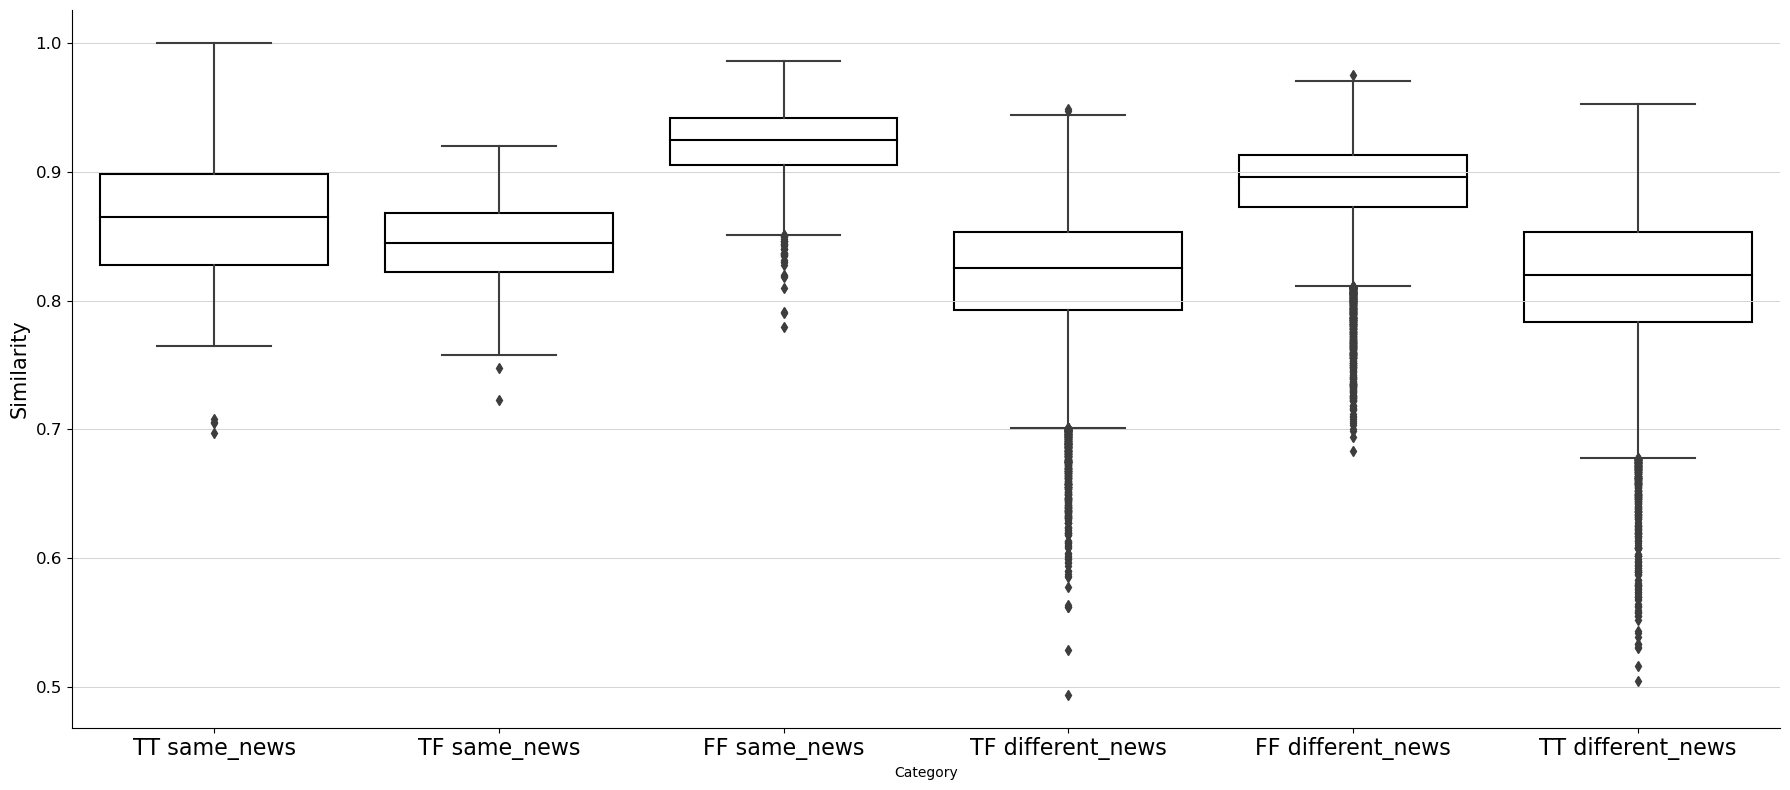

In [89]:
# Create a DataFrame from the provided data
data = {
    'TT same_news': similarity_tt_same,
    'TF same_news': similarity_tf_same,
    'FF same_news': similarity_ff_same,
    'TF different_news': similarity_tf_diff,
    'FF different_news': similarity_ff_diff,
    'TT different_news': similarity_tt_diff
}
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting
df_melted = df.melt(var_name='Category', value_name='Similarity')

# Set the size of the plot
plt.figure(figsize=(18, 8))

# Create a box plot with white boxes and black edges
sns.boxplot(x='Category', y='Similarity', data=df_melted,
            boxprops=dict(facecolor='white', edgecolor='black'),
            medianprops=dict(color='black'))

# Set title and labels with increased font size
#plt.title('Tweet Similarity, GPT-4', fontsize=20)
plt.ylabel('Similarity', fontsize=15)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)

# Add vertical grid lines with light color
plt.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.7)

# Remove the top and right spines for a cleaner look
sns.despine()

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()


### Plot

In [5]:
import matplotlib.pyplot as plt

In [2]:
similarities_gpt4 = pd.read_csv('similarities_gpt4.csv')
similarities_gpt4.head()

,link_text,similarity_gpt4_age,similarity_gpt4_arg,similarity_gpt4_edu,similarity_gpt4_gender,similarity_gpt4_name,similarity_gpt4_no_polit,similarity_gpt4_simple,similarity_gpt4_using,similarity_true
0,"\n\n\n\n\n\n\n\n\n\n\n\n\n\nWASHINGTON, June 1...",0.905504,0.868762,0.870254,0.925138,0.862955,0.932548,0.910697,0.883355,0.956601
1,\n\nA divided Supreme Court late Wednesday ref...,0.879667,0.899625,0.891505,0.903947,0.800860,0.914506,0.881148,0.891710,0.964090
2,"\n\nEditors’ Note, June 5, 2020:\n\nAfter publ...",0.897525,0.889595,0.898359,0.889789,0.786705,0.881378,0.887609,0.909984,0.941948
3,\n\nElizabeth Warren is a Democratic senator f...,0.890659,0.885010,0.883929,0.896084,0.815245,0.882379,0.874782,0.903300,0.934315
4,"\n\nFor a few years now, the leaders of the Re...",0.894064,0.891288,0.882593,0.883441,0.789215,0.849963,0.869481,0.854943,0.899973


In [12]:
columns = ['similarity_gpt4_simple', 'similarity_gpt4_no_polit',
       'similarity_gpt4_name', 'similarity_gpt4_using', 'similarity_gpt4_arg',
       'similarity_gpt4_edu', 'similarity_gpt4_age', 'similarity_gpt4_gender']

for col in columns: 
    print(similarities_gpt4[col].mean())

0.8786159809342561
0.8816931600000001
0.7821120339100346
0.8785065386505191
0.8804636962283737
0.879306925951557
0.881979580899654
0.8803945667128028


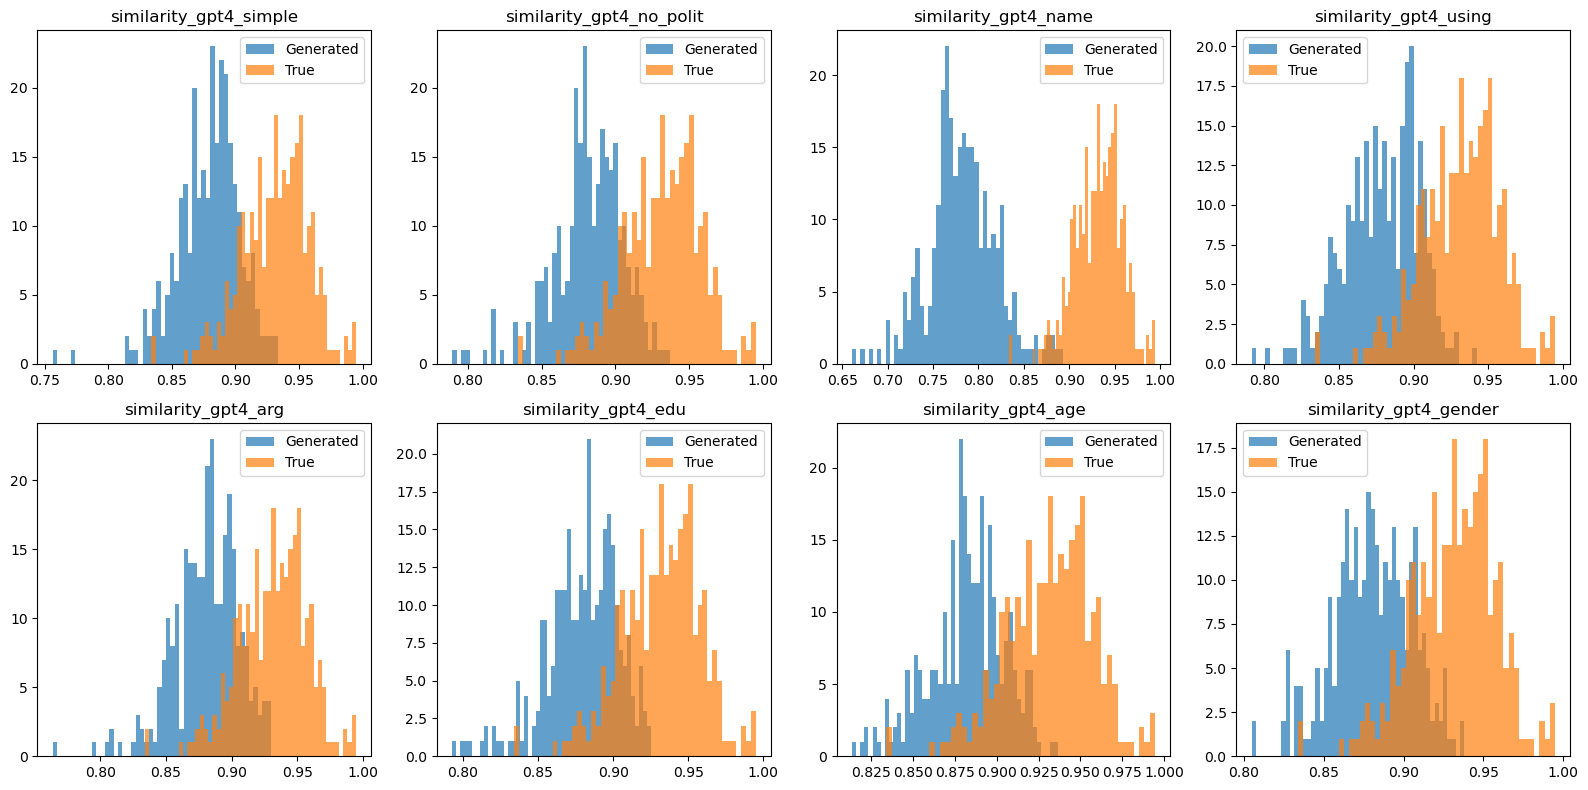

In [10]:
# Plotting
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))  
columns = ['similarity_gpt4_simple', 'similarity_gpt4_no_polit',
       'similarity_gpt4_name', 'similarity_gpt4_using', 'similarity_gpt4_arg',
       'similarity_gpt4_edu', 'similarity_gpt4_age', 'similarity_gpt4_gender']

#title = [simple]

# Flatten axs to easily access each subplot
axs = axs.flatten()

# Iterate over columns of original DataFrame
for i, col in enumerate(similarities_gpt4[columns]):
    ax = axs[i]
    ax.hist(similarities_gpt4[col], bins=50, alpha=0.7, label='Generated')  # Histogram from original DataFrame column
    ax.hist(similarities_gpt4['similarity_true'], bins=50, alpha=0.7, label='True')  # Histogram from pivot table column
    ax.set_title(col)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

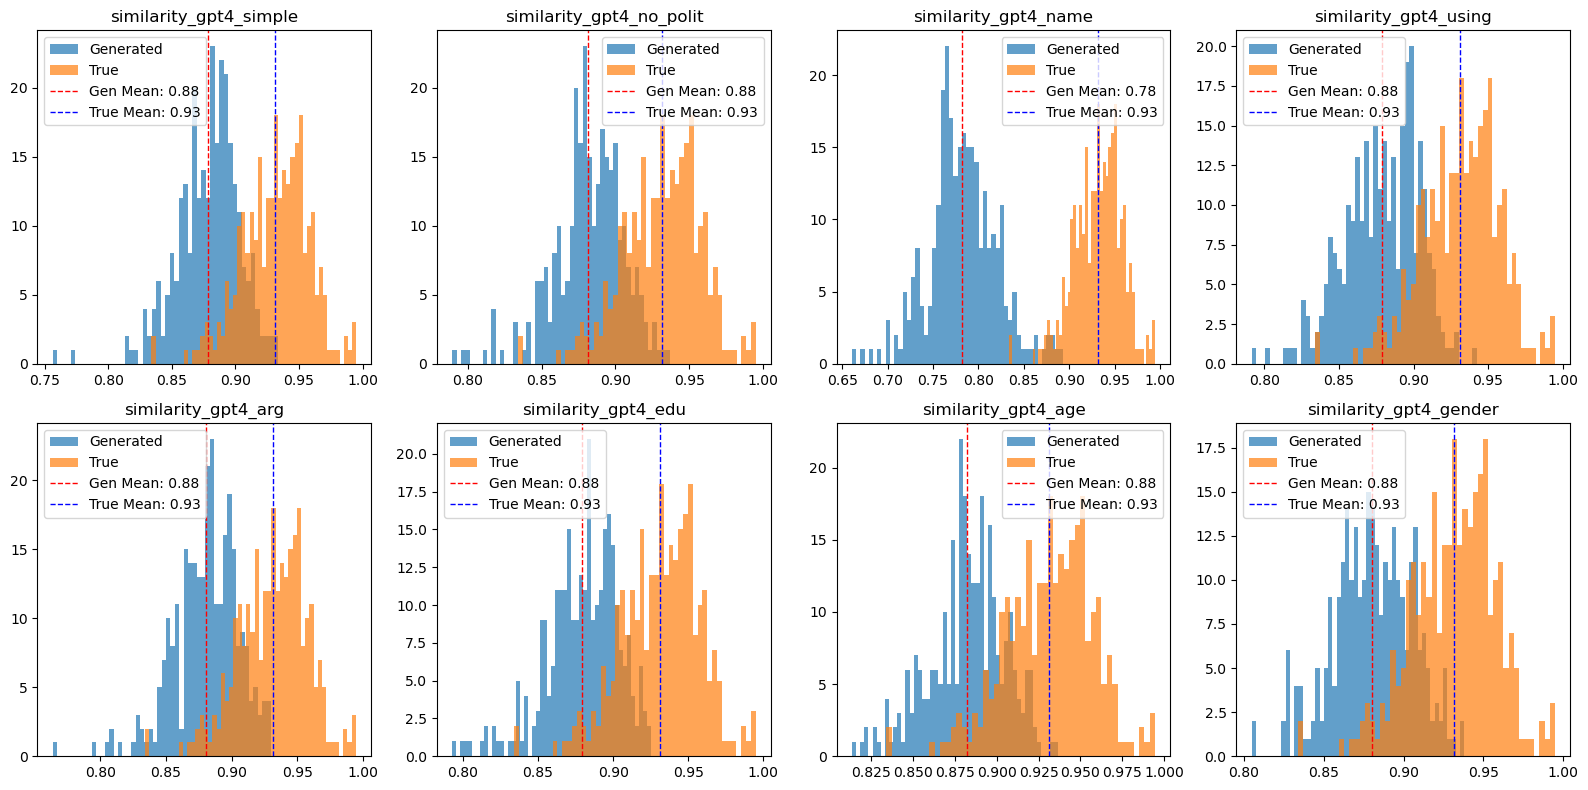

In [8]:
# Plotting
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))  
columns = ['similarity_gpt4_simple', 'similarity_gpt4_no_polit',
           'similarity_gpt4_name', 'similarity_gpt4_using', 
           'similarity_gpt4_arg', 'similarity_gpt4_edu', 
           'similarity_gpt4_age', 'similarity_gpt4_gender']

# Flatten axs to easily access each subplot
axs = axs.flatten()

# Iterate over columns of original DataFrame
for i, col in enumerate(similarities_gpt4[columns]):
    ax = axs[i]
    
    # Data for the current column and true similarity
    data_generated = similarities_gpt4[col]
    data_true = similarities_gpt4['similarity_true']
    
    # Calculate means
    mean_generated = data_generated.mean()
    mean_true = data_true.mean()
    
    # Plot histograms
    ax.hist(data_generated, bins=50, alpha=0.7, label='Generated')  
    ax.hist(data_true, bins=50, alpha=0.7, label='True')  
    
    # Add vertical lines for means
    ax.axvline(mean_generated, color='r', linestyle='dashed', linewidth=1, label=f'Gen Mean: {mean_generated:.2f}')
    ax.axvline(mean_true, color='b', linestyle='dashed', linewidth=1, label=f'True Mean: {mean_true:.2f}')
    
    # Set title and legend
    ax.set_title(col)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Semantic similarity for GPT3

In [13]:
df2 = pd.read_csv('gpt3_full_merged.csv')
df2.head(2)

,id,author_id,in_reply_to_user_id,quoted_user_id,retweeted_user_id,text,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,...,gpt3_using,gpt3_using_label,gpt3_arg,gpt3_arg_label,gpt3_edu,gpt3_edu_label,gpt3_age,gpt3_age_label,gpt3_gender,gpt3_gender_label
0,1174499599181959168,262192574,NaN,NaN,NaN,We should never forget the sacrifices made by ...,22,0,0,2,...,Honoring our Gold Star Families is vital to re...,Positive,As a proud representative of Mississippi and a...,Positive,"Senator Hyde-Smith's proposal to establish ""Go...",Positive,"As a proud Republican, I fully support U.S. Se...",Positive,"As a proud Republican, I fully support Senator...",Positive
1,1320738770543628288,15808765,NaN,NaN,NaN,It's no secret what Donald Trump and Senate Re...,1494,67,264,323,...,"As a lawyer, I can confirm that the ACA provid...",Negative,"As a Democrat, I am appalled by Trump's plan t...",Positive,"As a Democrat, I am appalled by Trump's desire...",Negative,"As a Democrat, I am deeply troubled by Trump's...",Negative,"President Trump's interview with ""60 Minutes"" ...",Negative


In [16]:
# drop duplicates 
df2 = df2.drop_duplicates(subset='text')

# find tweets commenting on the same news 
duplicated = df2[df2.duplicated(subset=['link_text'], keep=False)]

In [17]:
columns = ['gpt3_simple', 'gpt3_no_polit', 'gpt3_name', 
           'gpt3_using', 'gpt3_arg', 'gpt3_edu', 'gpt3_age', 'gpt3_gender']

In [18]:
similarity_gen_gpt3 = []

In [19]:
# Iterate over the rows and columns to calculate similarities
for index, row in tqdm(duplicated.iterrows(), total=duplicated.shape[0]):
    sentence1 = str(row['text'])
    
    similarity_row = {}
    
    for column in columns:
        sentence2 = str(row[column])
        
        # Get embeddings for both sentences
        embedding1 = get_embeddings(sentence1, tokenizer, model)
        embedding2 = get_embeddings(sentence2, tokenizer, model)
        
        # Calculate cosine similarity
        similarity = cosine_similarity(embedding1.numpy(), embedding2.numpy())  # Convert tensors to numpy arrays
        similarity_row[f'similarity_{column}'] = similarity[0][0]
    
    # Append the similarity row to the list
    similarity_gen_gpt3.append(similarity_row)

100%|█████████████████████████████████████████| 787/787 [08:05<00:00,  1.62it/s]


In [20]:
duplicated = duplicated.reset_index()
similarity_gen_gpt3 = pd.DataFrame(similarity_gen_gpt3)
similarity_gen_gpt3['link_text'] = duplicated['link_text']

In [21]:
similarity_gen_gpt3_pivot = similarity_gen_gpt3.pivot_table(index='link_text', values=['similarity_gpt3_simple', 'similarity_gpt3_no_polit',
       'similarity_gpt3_name', 'similarity_gpt3_using', 'similarity_gpt3_arg',
       'similarity_gpt3_edu', 'similarity_gpt3_age', 'similarity_gpt3_gender'],  aggfunc='mean')
similarity_gen_gpt3_pivot = similarity_gen_gpt3_pivot.reset_index()

In [22]:
similarity_gen_gpt3_pivot.head()

,link_text,similarity_gpt3_age,similarity_gpt3_arg,similarity_gpt3_edu,similarity_gpt3_gender,similarity_gpt3_name,similarity_gpt3_no_polit,similarity_gpt3_simple,similarity_gpt3_using
0,"\n\n\n\n\n\n\n\n\n\n\n\n\n\nWASHINGTON, June 1...",0.807873,0.880989,0.902023,0.857639,0.856320,0.898963,0.859510,0.880354
1,\n\nA divided Supreme Court late Wednesday ref...,0.889988,0.880990,0.876539,0.900365,0.893486,0.870098,0.883561,0.900901
2,"\n\nEditors’ Note, June 5, 2020:\n\nAfter publ...",0.881218,0.897904,0.909227,0.903078,0.900925,0.897098,0.870445,0.904345
3,\n\nElizabeth Warren is a Democratic senator f...,0.886822,0.878904,0.845456,0.874491,0.879872,0.871701,0.896641,0.846306
4,"\n\nFor a few years now, the leaders of the Re...",0.869753,0.860574,0.817203,0.846227,0.885559,0.888006,0.831368,0.868154


In [23]:
len(similarity_gen_gpt3_pivot)

289

In [24]:
similarity_gen_gpt3_pivot['similarity_true'] = similarities_gpt4['similarity_true']

In [25]:
similarity_gen_gpt3_pivot.to_csv('similarity_gpt3.csv', index = False)

In [26]:
similarity_gen_gpt3_pivot.head()

,link_text,similarity_gpt3_age,similarity_gpt3_arg,similarity_gpt3_edu,similarity_gpt3_gender,similarity_gpt3_name,similarity_gpt3_no_polit,similarity_gpt3_simple,similarity_gpt3_using,similarity_true
0,"\n\n\n\n\n\n\n\n\n\n\n\n\n\nWASHINGTON, June 1...",0.807873,0.880989,0.902023,0.857639,0.856320,0.898963,0.859510,0.880354,0.956601
1,\n\nA divided Supreme Court late Wednesday ref...,0.889988,0.880990,0.876539,0.900365,0.893486,0.870098,0.883561,0.900901,0.964090
2,"\n\nEditors’ Note, June 5, 2020:\n\nAfter publ...",0.881218,0.897904,0.909227,0.903078,0.900925,0.897098,0.870445,0.904345,0.941948
3,\n\nElizabeth Warren is a Democratic senator f...,0.886822,0.878904,0.845456,0.874491,0.879872,0.871701,0.896641,0.846306,0.934315
4,"\n\nFor a few years now, the leaders of the Re...",0.869753,0.860574,0.817203,0.846227,0.885559,0.888006,0.831368,0.868154,0.899973


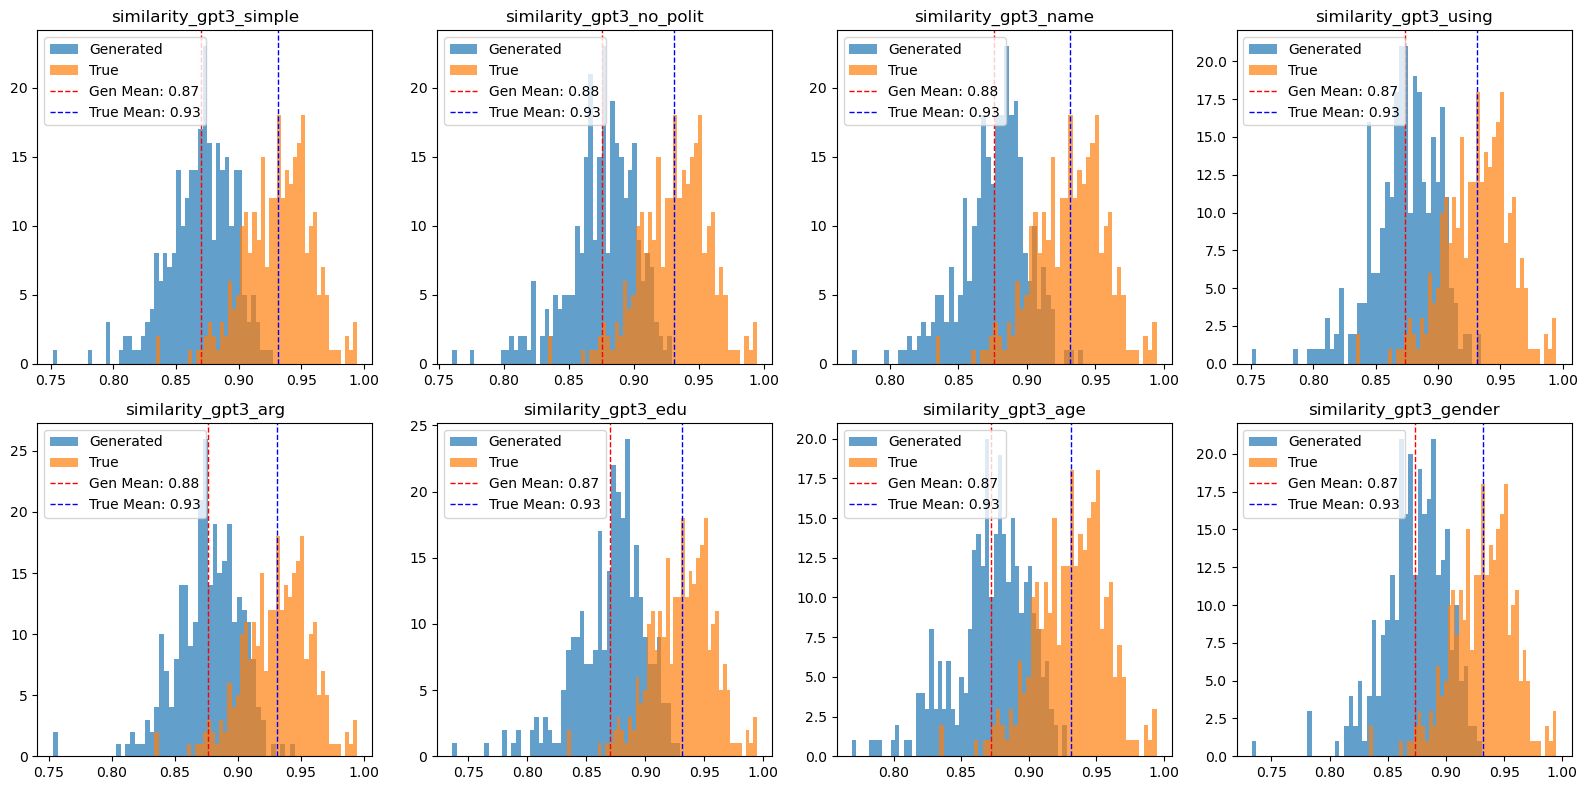

In [27]:
# Plotting
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))  
columns = ['similarity_gpt3_simple', 'similarity_gpt3_no_polit',
           'similarity_gpt3_name', 'similarity_gpt3_using', 
           'similarity_gpt3_arg', 'similarity_gpt3_edu', 
           'similarity_gpt3_age', 'similarity_gpt3_gender']

# Flatten axs to easily access each subplot
axs = axs.flatten()

# Iterate over columns of original DataFrame
for i, col in enumerate(similarity_gen_gpt3_pivot[columns]):
    ax = axs[i]
    
    # Data for the current column and true similarity
    data_generated = similarity_gen_gpt3_pivot[col]
    data_true = similarity_gen_gpt3_pivot['similarity_true']
    
    # Calculate means
    mean_generated = data_generated.mean()
    mean_true = data_true.mean()
    
    # Plot histograms
    ax.hist(data_generated, bins=50, alpha=0.7, label='Generated')  
    ax.hist(data_true, bins=50, alpha=0.7, label='True')  
    
    # Add vertical lines for means
    ax.axvline(mean_generated, color='r', linestyle='dashed', linewidth=1, label=f'Gen Mean: {mean_generated:.2f}')
    ax.axvline(mean_true, color='b', linestyle='dashed', linewidth=1, label=f'True Mean: {mean_true:.2f}')
    
    # Set title and legend
    ax.set_title(col)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()